## Heading here

Load the data and plot it.  Note that to make the index a time object in python, we need to do a conversion
$superscript^2 subscriot_7 x^{n-1}$

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


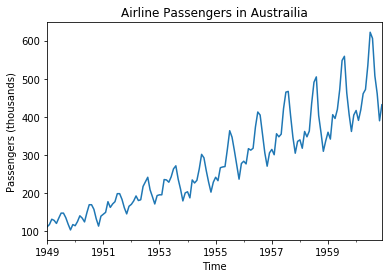

In [1]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
 
data = read_csv('AirPassengers.csv',sep=',')
air_pop=data['#Passengers']
air_pop.index=pd.to_datetime(data['Month'])
print(air_pop.head())
fig = plt.figure()

air_pop.plot()
plt.title("Airline Passengers in Austrailia")
plt.xlabel("Time")
plt.ylabel('Passengers (thousands)')
plt.show()


This is just a function that implements the Dickey-Fuller test and plots data along with rolling mean and standard deviation

In [2]:

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


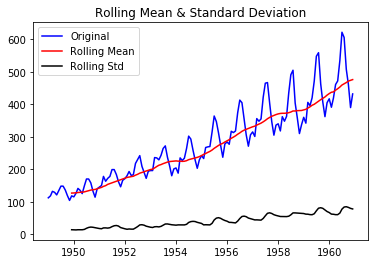

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [3]:
test_stationarity(air_pop)

Now we will subtract the trend from our data to make it (more) stationary

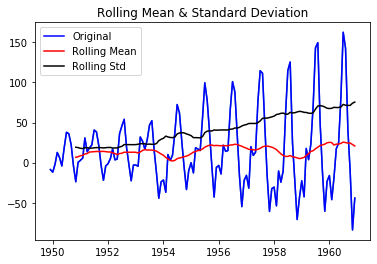

Results of Dickey-Fuller Test:
Test Statistic                  -3.164968
p-value                          0.022104
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [4]:
moving_avg = air_pop.rolling(12).mean()
no_trend = air_pop - moving_avg
plt.plot(no_trend)
plt.title("Passenger Data with Rolling Mean Removed")
test_stationarity(no_trend.dropna())

Now we do a variable change from y to ln y.  Not that in python the "log" function is actually natural log, ln.  Also note that the test statistic did not change hardly at all, even though the series looks much better.  
 
 In reality this data shows some seasonality, and there are seasonal models available, but for the purposes of the exercise we will ignore seasonality.

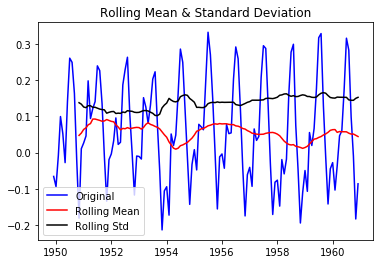

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [5]:
import numpy as np
log_air_pop=np.log(air_pop)
log_moving_avg = log_air_pop.rolling(12).mean()
log_no_trend=log_air_pop - log_moving_avg
test_stationarity(log_no_trend.dropna())

This next set of charts simply shows all the pieces of the function.  Note that while it does include seasonality, there still seems to be residual seasonality in the residuals.

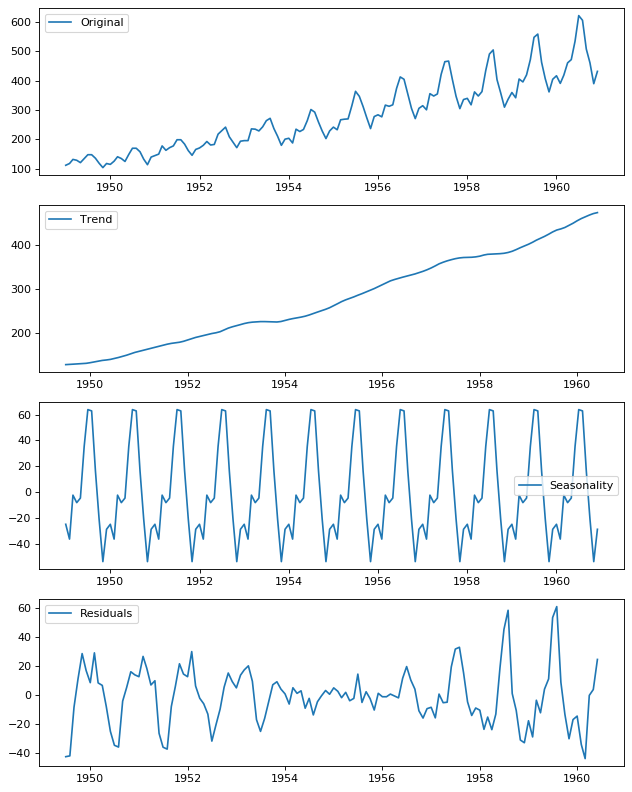

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(air_pop)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(411)
plt.plot(air_pop, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Next we will try some differencing to try and eliminate seasonality and make the series further stationary.  This determines if we use a difference term or not.  In this example, 1 shift ($y_t - y_{t-1}$) is used, so d=1

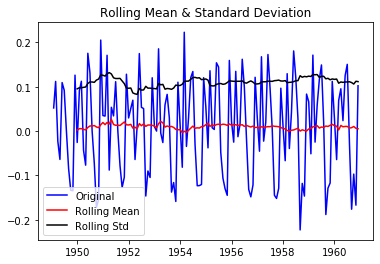

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [7]:
diff_air_pop = log_air_pop-log_air_pop.shift(1) # Changing the shift value is equivalent to changing your 'd' value
test_stationarity(diff_air_pop.dropna())

Now we take a look at the Autocorrelation and Partial Autocorrelation plots

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

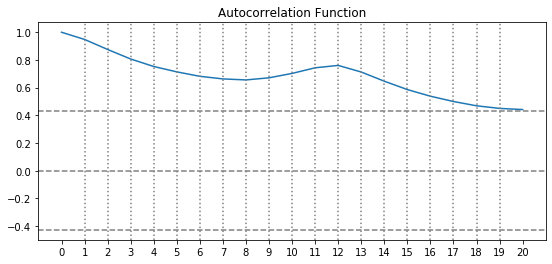

In [8]:
from statsmodels.tsa.stattools import acf, pacf
acf_air_plot = acf(air_pop.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

Text(0.5, 1.0, 'Partial Autocorrelation Function')

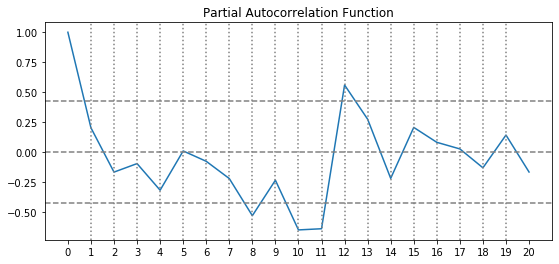

In [9]:
pacf_air_plot = pacf(diff_air_pop.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

Now we fit a model of the proper order and look at the output

**Since both the Autocorrelation and Partial Autocorrelation plots showed a drop at Lag 1 to within our confidence ranges - we'll start with a (1,0,1) ARIMA model.**  A (1,0,0) would likely fit equally well.

In [10]:
from statsmodels.tsa.arima_model import ARIMA


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:            #Passengers   No. Observations:                  143
Model:                     ARMA(1, 1)   Log Likelihood                 124.804
Method:                       css-mle   S.D. of innovations              0.101
Date:                Sat, 19 Oct 2019   AIC                           -241.608
Time:                        09:11:03   BIC                           -229.756
Sample:                    02-01-1949   HQIC                          -236.792
                         - 12-01-1960                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0098      0.010      0.993      0.322      -0.010       0.029
ar.L1.#Passengers    -0.5826      0.128     -4.536      0.000      -0.834      -0.331
ma.L1.#Passengers     0.

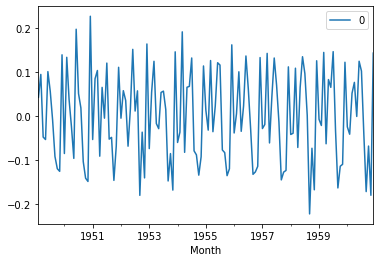

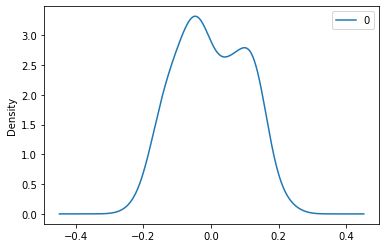

                0
count  143.000000
mean    -0.000026
std      0.101389
min     -0.223351
25%     -0.078643
50%     -0.009057
75%      0.089547
max      0.227127


In [11]:
model = ARIMA(diff_air_pop.dropna(), order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

**That bi-modal density is not the best - we may need some differencing!**

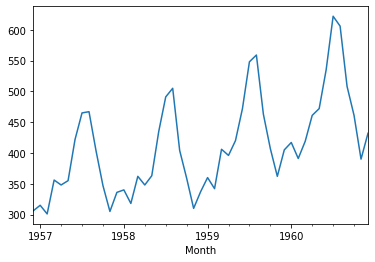

In [12]:

air_pop[-49:].plot()

Now I am just going to do a brute force search for parameters and find the best  ones.

1.2697630431892135


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


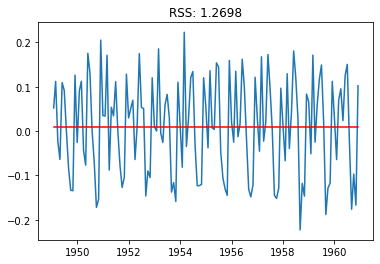

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


0 0 0
1.2347218948480452


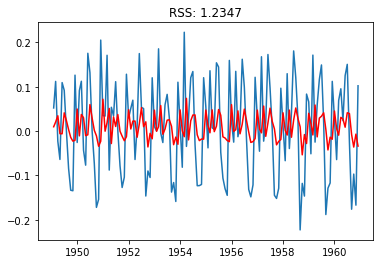

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


0 0 1
1.2133178210414859


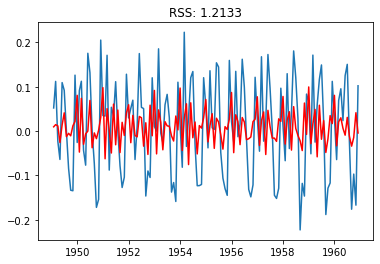

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


0 0 2


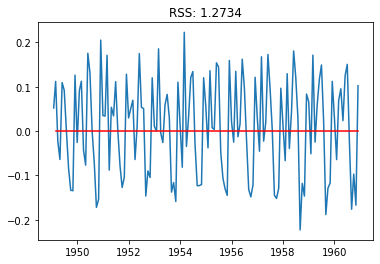

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


0 1 0


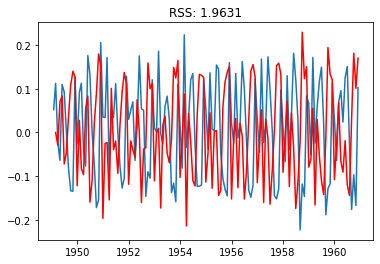

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


0 1 1


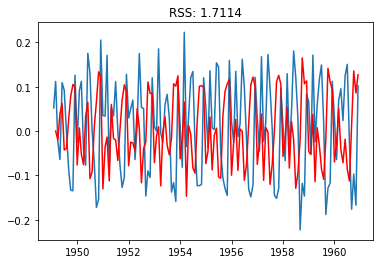

0 1 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


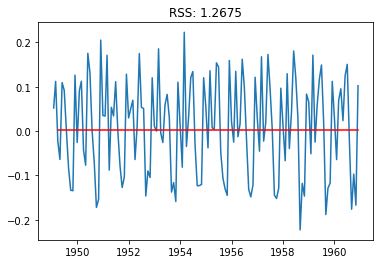

0 2 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


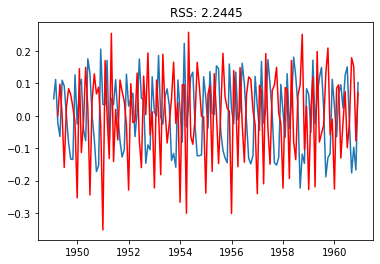

0 2 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


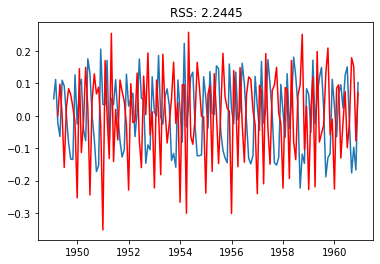

0 2 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


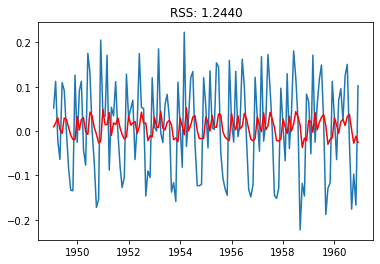

1 0 0
1.2081934021545486


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


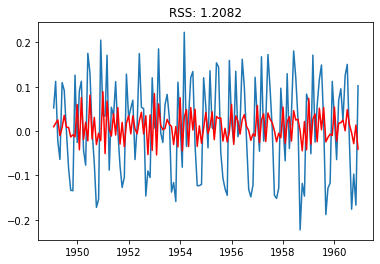

1 0 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


1.1033131556351927


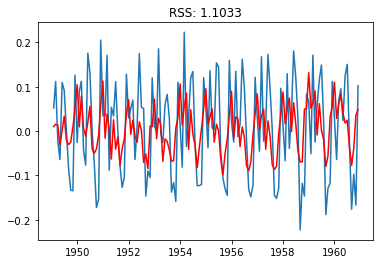

1 0 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


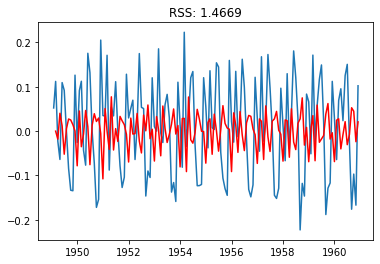

1 1 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


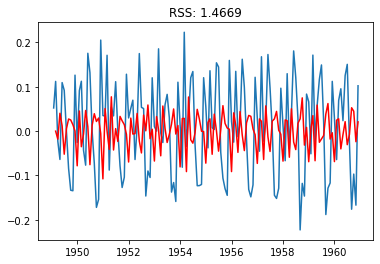

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


1 1 1


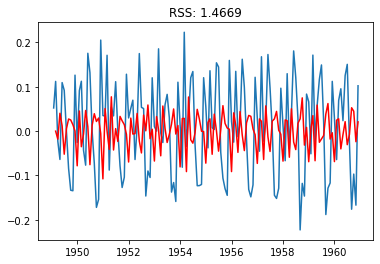

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


1 1 2


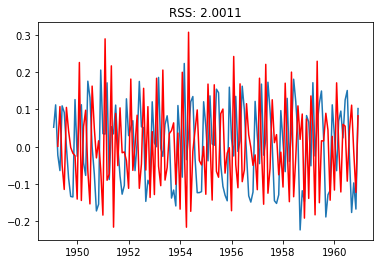

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


1 2 0


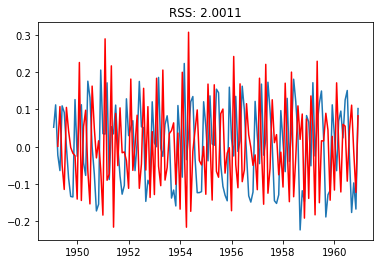

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


1 2 1


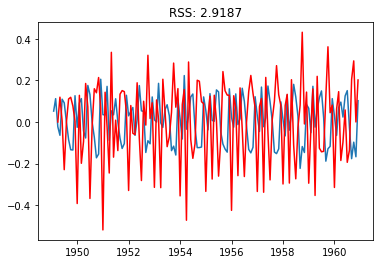

1 2 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


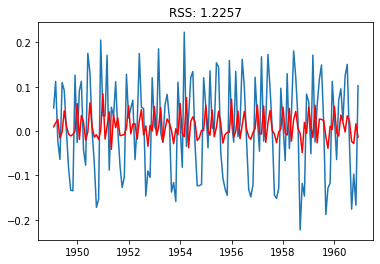

2 0 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


1.0841183492735074


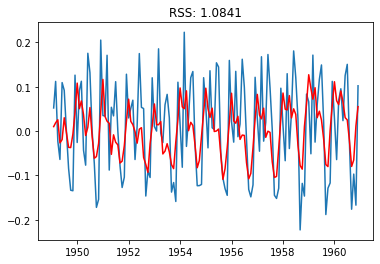

2 0 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


1.0144712914381224


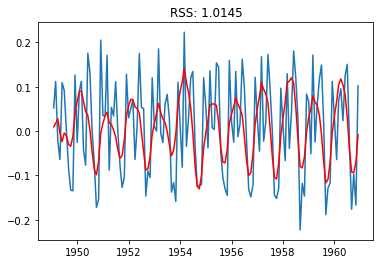

2 0 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


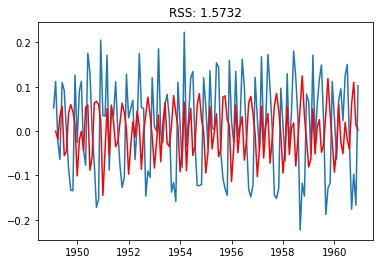

2 1 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


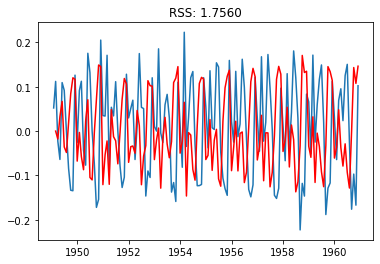

2 1 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


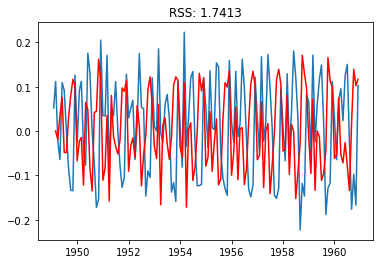

2 1 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


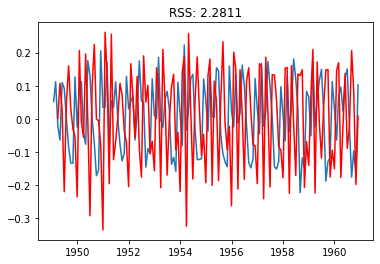

2 2 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


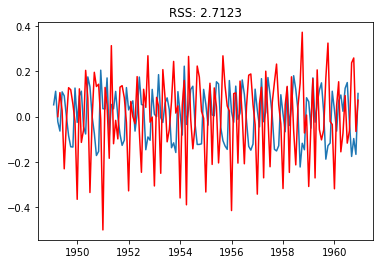

2 2 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


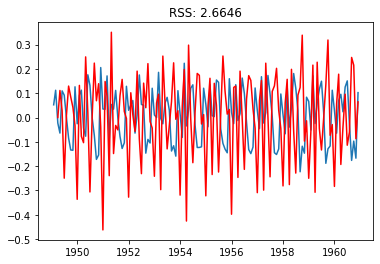

2 2 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


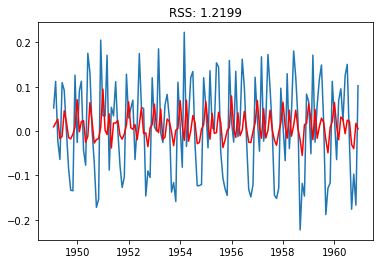

3 0 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


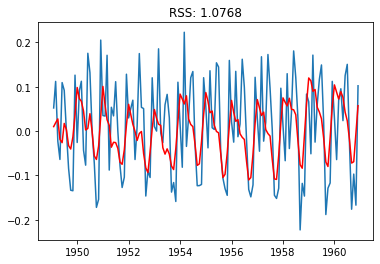

3 0 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


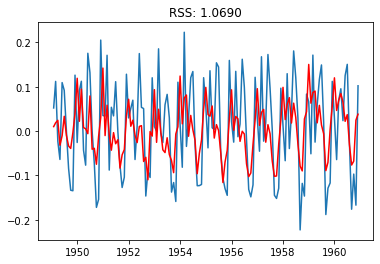

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


3 0 2


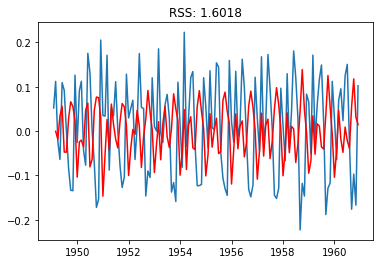

3 1 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


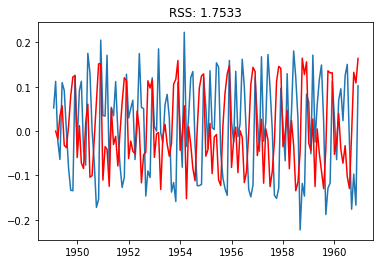

3 1 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


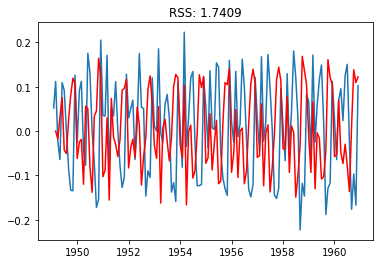

3 1 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


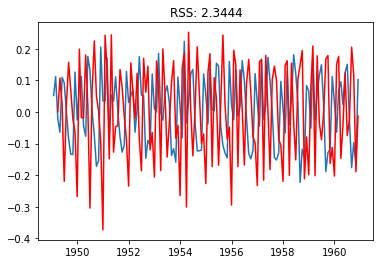

3 2 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


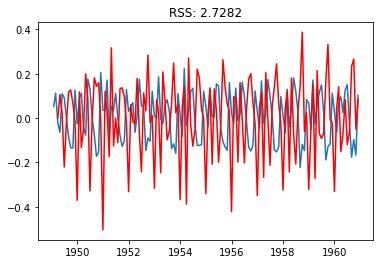

3 2 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


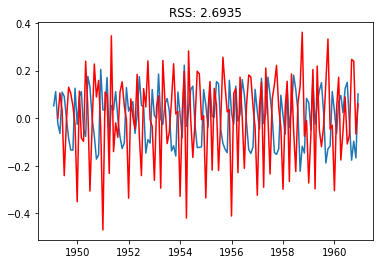

3 2 2


In [13]:
air_pop = air_pop.astype(float)
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff_air_pop.dropna(), order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff_air_pop)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff_air_pop)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

1434.5884983932579


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


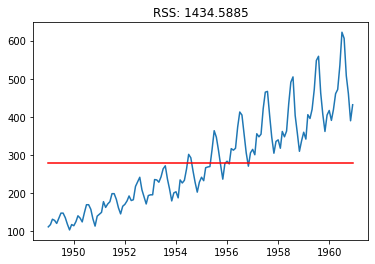

0 0 0
794.3923367776297

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


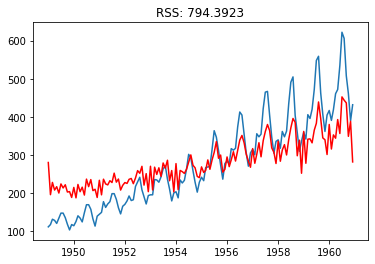

0 0 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


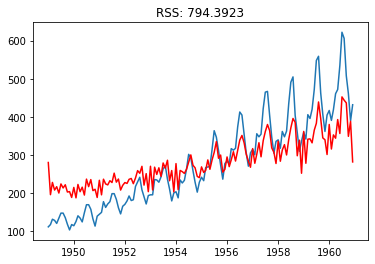

0 0 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


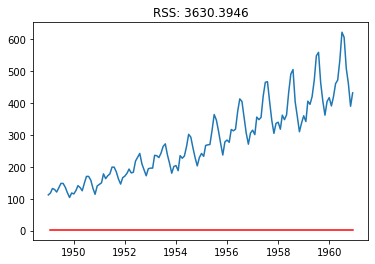

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


0 1 0


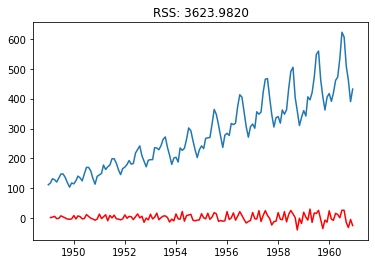

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


0 1 1


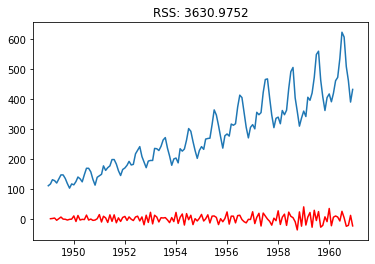

0 1 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


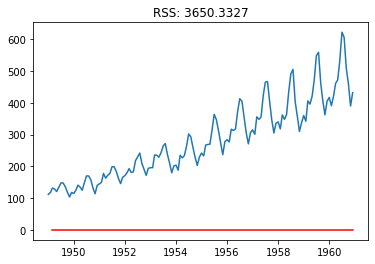

0 2 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


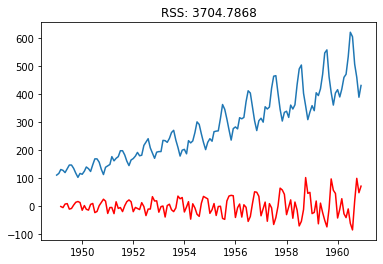

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


0 2 1


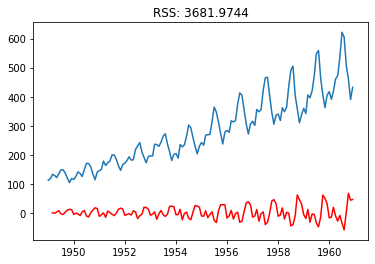

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


0 2 2
432.1233471501475


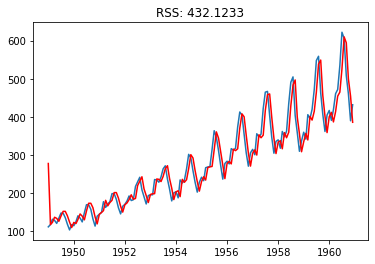

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


1 0 0
407.94301336780615


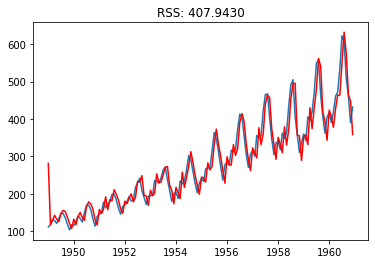

1 0 1
407.20617434978203


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


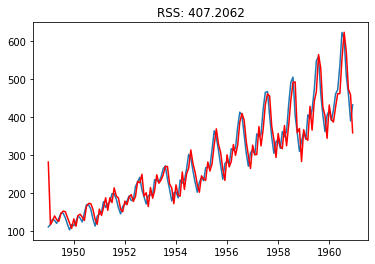

1 0 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


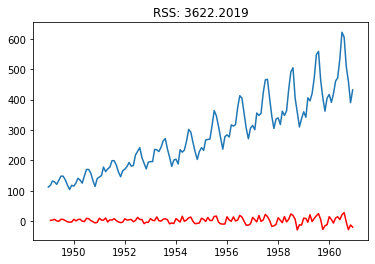

1 1 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


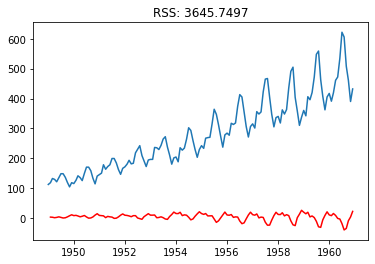

1 1 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


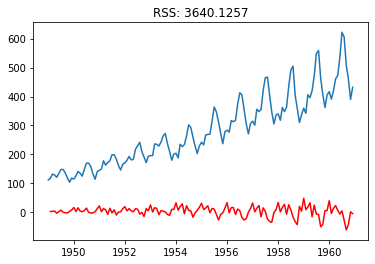

1 1 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


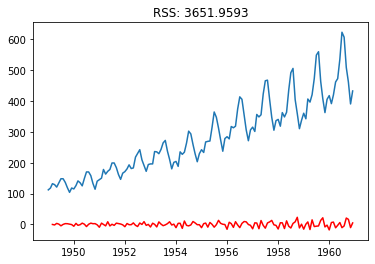

1 2 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


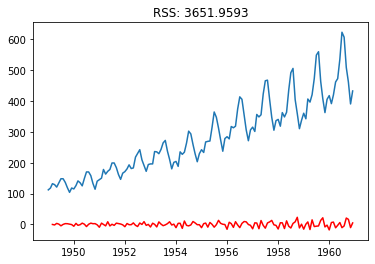

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


1 2 1


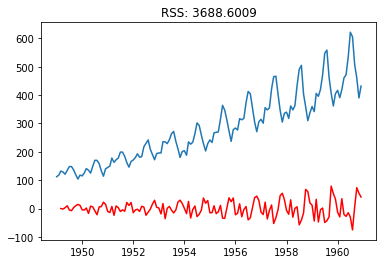

1 2 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


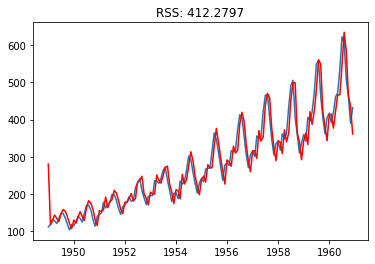

2 0 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


403.5901418516768


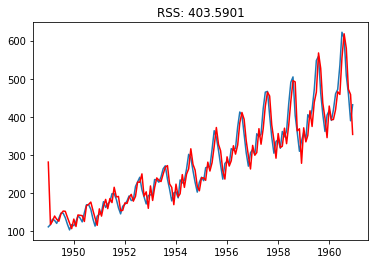

2 0 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


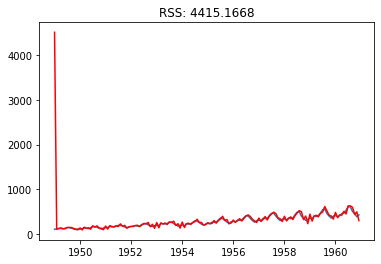

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


2 0 2


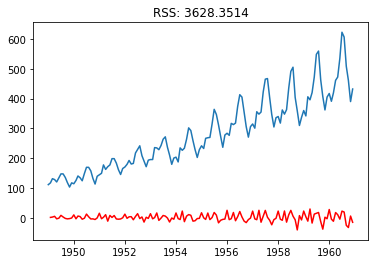

2 1 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


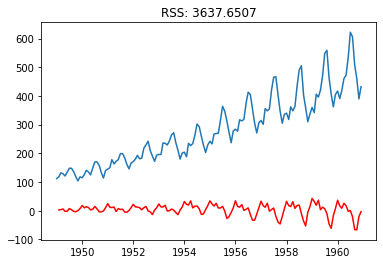

2 1 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


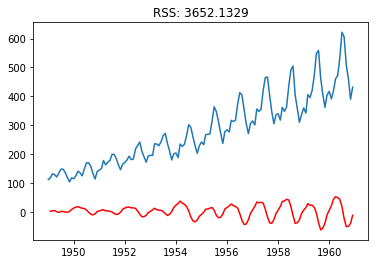

2 1 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


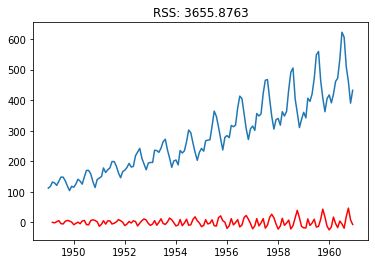

2 2 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


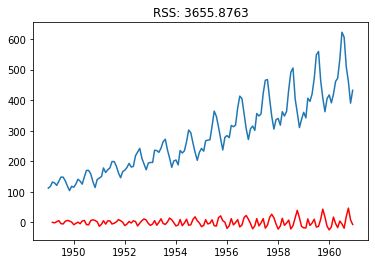

2 2 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


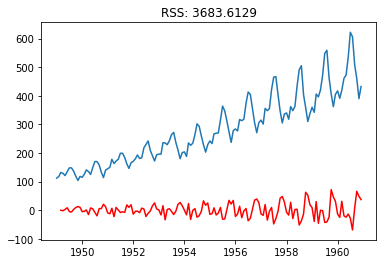

2 2 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


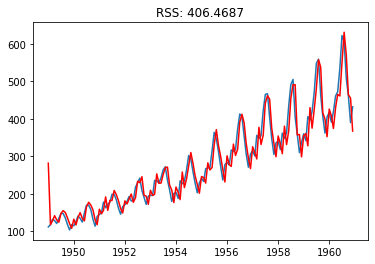

3 0 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


386.5303618193142


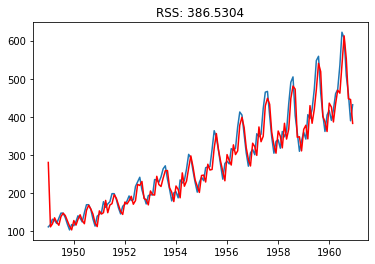

3 0 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


356.03814062675224


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


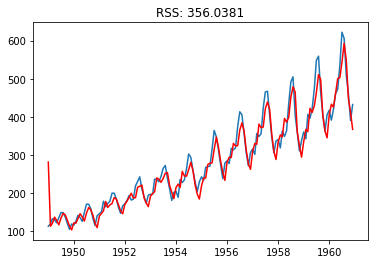

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


3 0 2


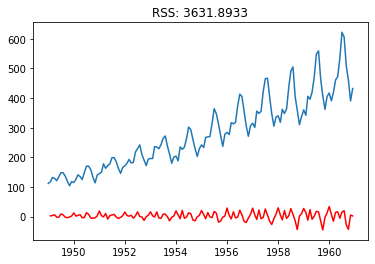

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


3 1 0


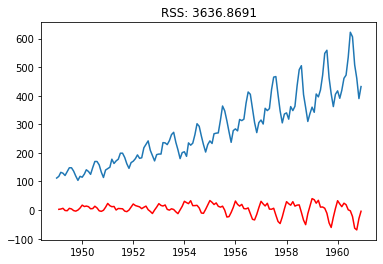

3 1 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


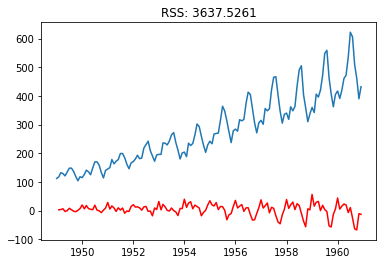

3 1 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


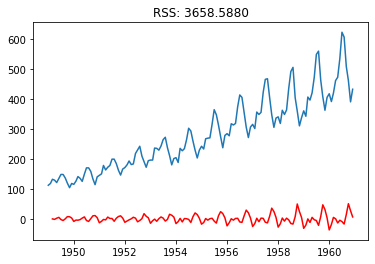

3 2 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


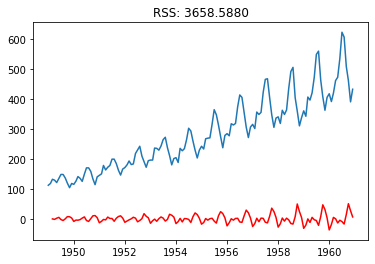

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


3 2 1


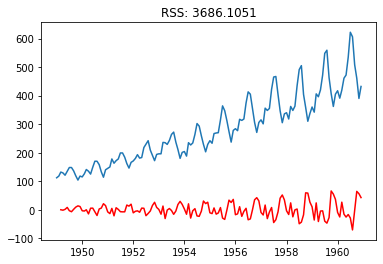

3 2 2


In [14]:
air_pop = air_pop.astype(float)
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(air_pop.dropna(), order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(air_pop)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(air_pop)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [15]:
print(loss_best)
print(best_ints)


356.03814062675224
[3, 0, 2]


**Is this the best answer?  Why or why not?**

No, it violates RULES 8.  With an AR (p) of 3, your MA (q) must be 1 or 0.  You might need to write a function to eliminate these scenarios from your "best" list.

## Stock Prices with ARIMA

In [16]:
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web
start = datetime.datetime(2013, 6, 3)
end = datetime.datetime(2019, 10, 15)
# Change 'iex' to 'yahoo' and capitalize 'close'
price = web.DataReader('WMT', 'yahoo', start, end)['Close']
price.index = pd.to_datetime(price.index)

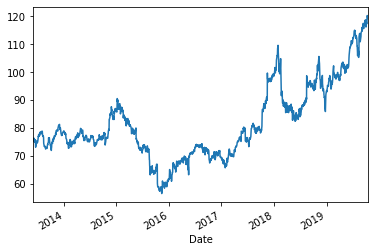

In [17]:
price.plot()

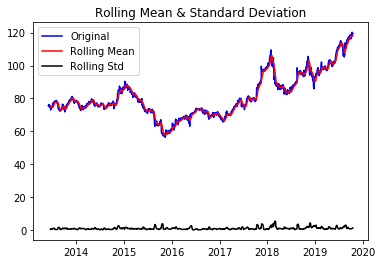

Results of Dickey-Fuller Test:
Test Statistic                    0.050446
p-value                           0.962510
#Lags Used                        1.000000
Number of Observations Used    1604.000000
Critical Value (1%)              -3.434433
Critical Value (5%)              -2.863344
Critical Value (10%)             -2.567730
dtype: float64


In [18]:
test_stationarity(price)

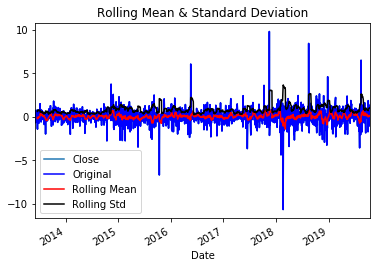

Results of Dickey-Fuller Test:
Test Statistic                  -41.768693
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1604.000000
Critical Value (1%)              -3.434433
Critical Value (5%)              -2.863344
Critical Value (10%)             -2.567730
dtype: float64


In [19]:
diff=price-price.shift()
diff.dropna(inplace=True)
diff.plot()
test_stationarity(diff)

### Without differencing, your Autocorrelation Plot looks like this:

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

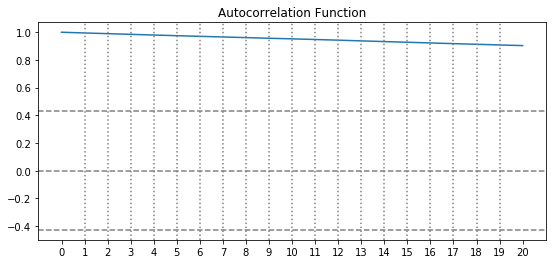

In [20]:
acf_air_plot = acf(price, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

### With differencing, the plot converts to:

Text(0.5, 1.0, 'Partial Autocorrelation Function')

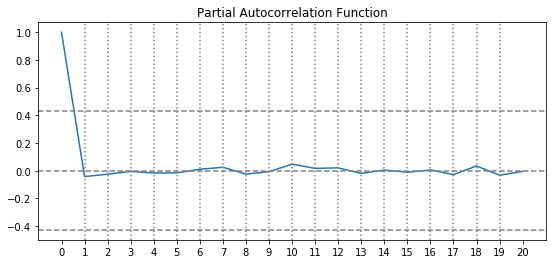

In [21]:
pacf_air_plot = pacf(diff, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1605
Model:                     ARMA(1, 0)   Log Likelihood               -2216.665
Method:                       css-mle   S.D. of innovations              0.963
Date:                Sat, 19 Oct 2019   AIC                           4439.331
Time:                        09:11:25   BIC                           4455.474
Sample:                             0   HQIC                          4445.324
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0272      0.023      1.182      0.237      -0.018       0.072
ar.L1.Close    -0.0426      0.025     -1.708      0.088      -0.091       0.006
                                    Roots       

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


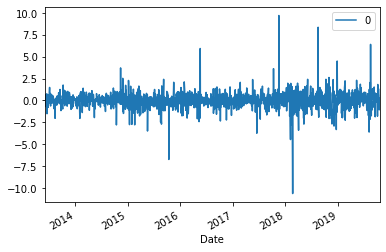

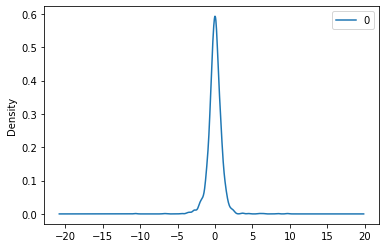

                 0
count  1605.000000
mean      0.000006
std       0.963168
min     -10.632401
25%      -0.435654
50%       0.014161
75%       0.452226
max       9.707944


In [22]:
model = ARIMA(diff, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

38.609907164914304


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


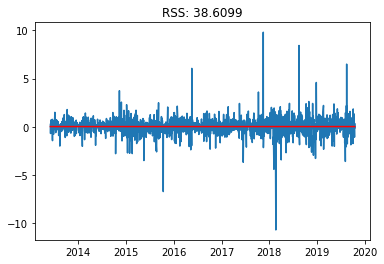

0 0 0
                  0        Close          out
count  1.605000e+03  1605.000000  1605.000000
mean   2.724610e-02     0.027246     0.928801
std    4.925078e-16     0.964043     4.689052
min    2.724610e-02   -10.669998     0.000008
25%    2.724610e-02    -0.409996     0.038905
50%    2.724610e-02     0.040001     0.191187
75%    2.724610e-02     0.480003     0.676934
max    2.724610e-02     9.790001   114.431035


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


38.57303418493646


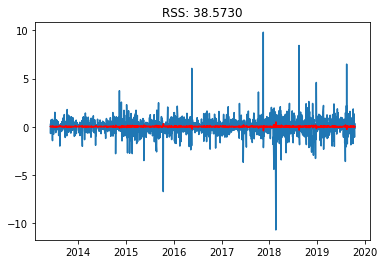

0 0 1
                 0        Close           out
count  1605.000000  1605.000000  1.605000e+03
mean      0.027241     0.027246  9.270274e-01
std       0.043138     0.964043  4.642522e+00
min      -0.407450   -10.669998  1.566091e-07
25%       0.006903    -0.409996  3.640168e-02
50%       0.026638     0.040001  1.952300e-01
75%       0.046795     0.480003  6.765264e-01
max       0.503176     9.790001  1.129110e+02
38.56168072214432


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


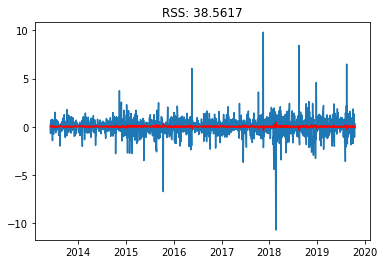

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 0 2
                 0        Close           out
count  1605.000000  1605.000000  1.605000e+03
mean      0.027248     0.027246  9.264818e-01
std       0.048525     0.964043  4.636837e+00
min      -0.367942   -10.669998  1.303296e-08
25%       0.003561    -0.409996  3.614591e-02
50%       0.027125     0.040001  1.957541e-01
75%       0.050180     0.480003  6.649163e-01
max       0.452978     9.790001  1.121007e+02


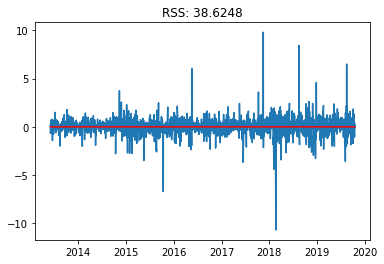

0 1 0
                  0        Close           out
count  1.604000e+03  1604.000000  1.604000e+03
mean  -2.244393e-04     0.027107  9.300957e-01
std    1.153844e-17     0.964328  4.691999e+00
min   -2.244393e-04   -10.669998  5.037299e-08
25%   -2.244393e-04    -0.409998  3.618627e-02
50%   -2.244393e-04     0.040001  1.937997e-01
75%   -2.244393e-04     0.480003  6.722155e-01
max   -2.244393e-04     9.790001  1.138441e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


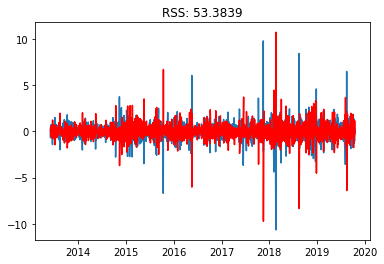

0 1 1
                 0        Close           out
count  1604.000000  1604.000000  1.604000e+03
mean      0.006897     0.027107  1.776709e+00
std       0.962574     0.964328  6.786893e+00
min      -9.726273   -10.669998  6.912987e-07
25%      -0.444647    -0.409998  7.575931e-02
50%      -0.005153     0.040001  4.051412e-01
75%       0.433668     0.480003  1.362806e+00
max      10.730325     9.790001  1.774312e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


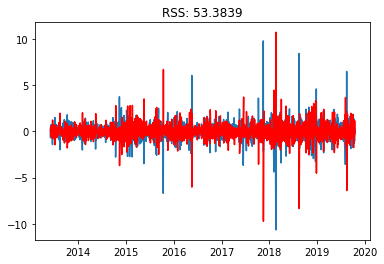

0 1 2
                 0        Close           out
count  1604.000000  1604.000000  1.604000e+03
mean      0.006897     0.027107  1.776709e+00
std       0.962574     0.964328  6.786893e+00
min      -9.726273   -10.669998  6.912987e-07
25%      -0.444647    -0.409998  7.575931e-02
50%      -0.005153     0.040001  4.051412e-01
75%       0.433668     0.480003  1.362806e+00
max      10.730325     9.790001  1.774312e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


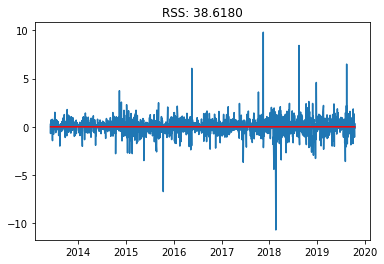

0 2 0
                  0        Close           out
count  1.603000e+03  1603.000000  1.603000e+03
mean   2.932010e-04     0.027555  9.303506e-01
std    1.115196e-16     0.964462  4.693415e+00
min    2.932010e-04   -10.669998  8.596683e-08
25%    2.932010e-04    -0.409996  3.621243e-02
50%    2.932010e-04     0.040001  1.938603e-01
75%    2.932010e-04     0.480003  6.719187e-01
max    2.932010e-04     9.790001  1.138551e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


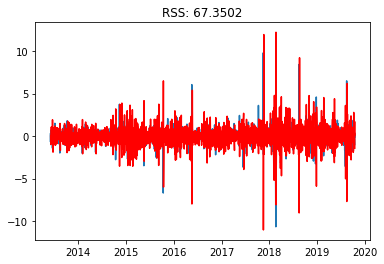

0 2 1
                 0        Close           out
count  1603.000000  1603.000000  1.603000e+03
mean     -0.001536     0.027555  2.829724e+00
std       1.391303     0.964462  9.980644e+00
min     -11.041387   -10.669998  5.767175e-09
25%      -0.659982    -0.409996  1.415053e-01
50%      -0.000907     0.040001  6.725982e-01
75%       0.644790     0.480003  2.099676e+00
max      12.210895     9.790001  2.190666e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


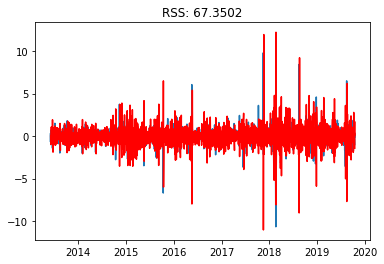

0 2 2
                 0        Close           out
count  1603.000000  1603.000000  1.603000e+03
mean     -0.001536     0.027555  2.829724e+00
std       1.391303     0.964462  9.980644e+00
min     -11.041387   -10.669998  5.767175e-09
25%      -0.659982    -0.409996  1.415053e-01
50%      -0.000907     0.040001  6.725982e-01
75%       0.644790     0.480003  2.099676e+00
max      12.210895     9.790001  2.190666e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


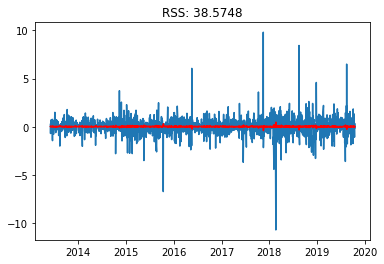

1 0 0
                 0        Close           out
count  1605.000000  1605.000000  1.605000e+03
mean      0.027240     0.027246  9.271145e-01
std       0.041050     0.964043  4.645212e+00
min      -0.388472   -10.669998  1.003125e-07
25%       0.007965    -0.409996  3.702990e-02
50%       0.026701     0.040001  1.970709e-01
75%       0.045862     0.480003  6.746603e-01
max       0.482751     9.790001  1.130479e+02

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



38.55950049543179


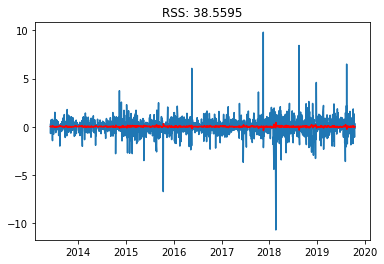

1 0 1
                 0        Close          out
count  1605.000000  1605.000000  1605.000000
mean      0.027248     0.027246     0.926377
std       0.049207     0.964043     4.632257
min      -0.382805   -10.669998     0.000002
25%       0.003802    -0.409996     0.036125
50%       0.025981     0.040001     0.195957
75%       0.051126     0.480003     0.661511
max       0.441912     9.790001   111.908392


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


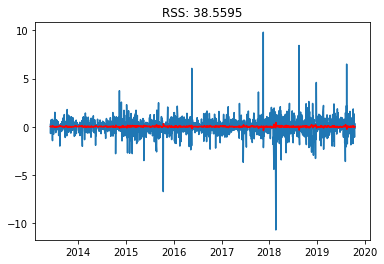

1 0 2
                 0        Close          out
count  1605.000000  1605.000000  1605.000000
mean      0.027248     0.027246     0.926377
std       0.049207     0.964043     4.632257
min      -0.382805   -10.669998     0.000002
25%       0.003802    -0.409996     0.036125
50%       0.025981     0.040001     0.195957
75%       0.051126     0.480003     0.661511
max       0.441912     9.790001   111.908392


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


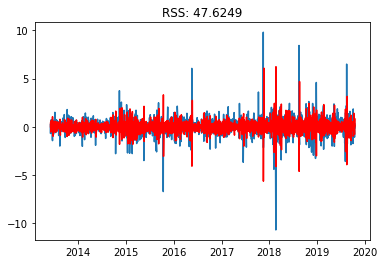

1 1 0
                 0        Close           out
count  1604.000000  1604.000000  1.604000e+03
mean      0.000074     0.027107  1.414046e+00
std       0.708730     0.964328  5.216131e+00
min      -5.624033   -10.669998  6.768146e-07
25%      -0.335815    -0.409998  6.395040e-02
50%       0.000105     0.040001  3.359656e-01
75%       0.330938     0.480003  1.077336e+00
max       6.219747     9.790001  1.136342e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


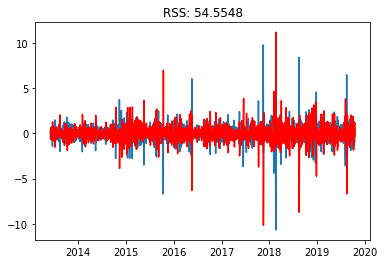

1 1 1
                 0        Close           out
count  1604.000000  1604.000000  1.604000e+03
mean      0.007160     0.027107  1.855500e+00
std       1.004400     0.964328  7.133527e+00
min     -10.148411   -10.669998  5.147729e-07
25%      -0.463933    -0.409998  7.951219e-02
50%      -0.005392     0.040001  4.096989e-01
75%       0.452497     0.480003  1.426383e+00
max      11.196022     9.790001  1.900545e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


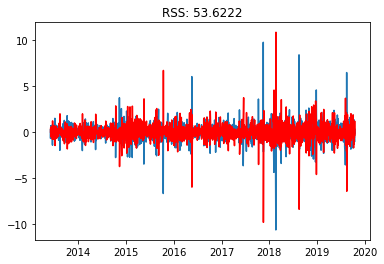

1 1 2
                 0        Close           out
count  1604.000000  1604.000000  1.604000e+03
mean      0.006887     0.027107  1.792606e+00
std       0.973231     0.964328  6.865619e+00
min      -9.844588   -10.669998  8.702148e-08
25%      -0.455541    -0.409998  7.705049e-02
50%      -0.000641     0.040001  4.159628e-01
75%       0.442625     0.480003  1.383202e+00
max      10.886540     9.790001  1.816172e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


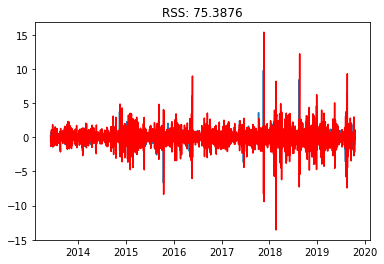

1 2 0
                 0        Close           out
count  1603.000000  1603.000000  1.603000e+03
mean     -0.000545     0.027555  3.545411e+00
std       1.616927     0.964462  1.235434e+01
min     -13.566511   -10.669998  1.134388e-07
25%      -0.751423    -0.409996  1.667369e-01
50%       0.000454     0.040001  8.588677e-01
75%       0.795745     0.480003  2.816677e+00
max      15.365194     9.790001  2.357819e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


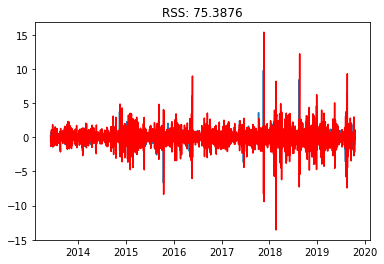

1 2 1
                 0        Close           out
count  1603.000000  1603.000000  1.603000e+03
mean     -0.000545     0.027555  3.545411e+00
std       1.616927     0.964462  1.235434e+01
min     -13.566511   -10.669998  1.134388e-07
25%      -0.751423    -0.409996  1.667369e-01
50%       0.000454     0.040001  8.588677e-01
75%       0.795745     0.480003  2.816677e+00
max      15.365194     9.790001  2.357819e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


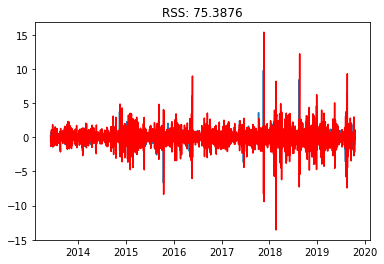

1 2 2
                 0        Close           out
count  1603.000000  1603.000000  1.603000e+03
mean     -0.000545     0.027555  3.545411e+00
std       1.616927     0.964462  1.235434e+01
min     -13.566511   -10.669998  1.134388e-07
25%      -0.751423    -0.409996  1.667369e-01
50%       0.000454     0.040001  8.588677e-01
75%       0.795745     0.480003  2.816677e+00
max      15.365194     9.790001  2.357819e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


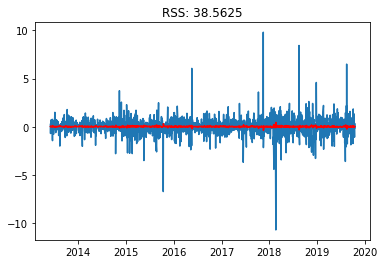

2 0 0
                 0        Close           out
count  1605.000000  1605.000000  1.605000e+03
mean      0.027248     0.027246  9.265206e-01
std       0.047730     0.964043  4.638411e+00
min      -0.366407   -10.669998  9.924379e-09
25%       0.004349    -0.409996  3.601987e-02
50%       0.027248     0.040001  1.957802e-01
75%       0.049903     0.480003  6.690445e-01
max       0.455745     9.790001  1.122067e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


38.55942318592885


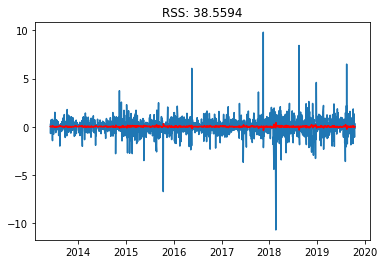

2 0 1
                 0        Close          out
count  1605.000000  1605.000000  1605.000000
mean      0.027249     0.027246     0.926373
std       0.049245     0.964043     4.632466
min      -0.374260   -10.669998     0.000001
25%       0.003026    -0.409996     0.036369
50%       0.026325     0.040001     0.195900
75%       0.051145     0.480003     0.659510
max       0.433272     9.790001   111.878092


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


38.55884526547973


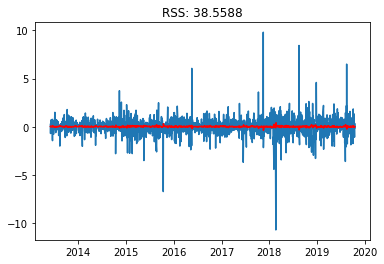

2 0 2
                 0        Close           out
count  1605.000000  1605.000000  1.605000e+03
mean      0.027249     0.027246  9.263455e-01
std       0.049526     0.964043  4.633155e+00
min      -0.362666   -10.669998  3.837375e-08
25%       0.003934    -0.409996  3.632558e-02
50%       0.026359     0.040001  1.966653e-01
75%       0.051293     0.480003  6.624034e-01
max       0.427192     9.790001  1.118109e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


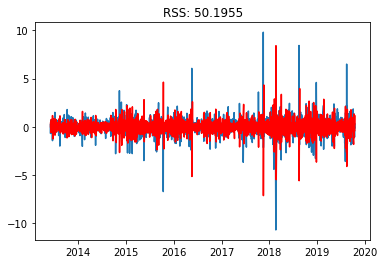

2 1 0
                 0        Close           out
count  1604.000000  1604.000000  1.604000e+03
mean      0.000045     0.027107  1.570813e+00
std       0.823919     0.964328  5.683404e+00
min      -7.120090   -10.669998  5.200099e-08
25%      -0.401379    -0.409998  7.636450e-02
50%       0.015103     0.040001  3.505274e-01
75%       0.385318     0.480003  1.277863e+00
max       8.394247     9.790001  1.206538e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


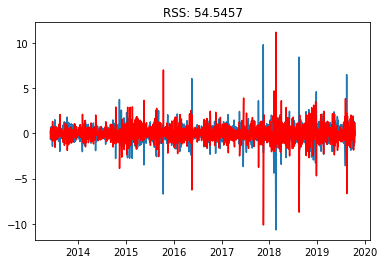

2 1 1
                 0        Close           out
count  1604.000000  1604.000000  1.604000e+03
mean      0.007415     0.027107  1.854882e+00
std       1.004713     0.964328  7.114256e+00
min     -10.125214   -10.669998  5.284464e-07
25%      -0.461238    -0.409998  7.832138e-02
50%      -0.012062     0.040001  4.120922e-01
75%       0.456365     0.480003  1.428703e+00
max      11.169742     9.790001  1.893306e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-par

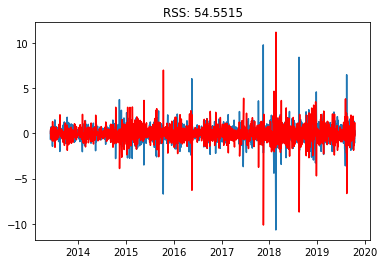

2 1 2
                 0        Close           out
count  1604.000000  1604.000000  1.604000e+03
mean      0.007261     0.027107  1.855275e+00
std       1.004729     0.964328  7.124203e+00
min     -10.128547   -10.669998  9.322914e-07
25%      -0.460697    -0.409998  8.098453e-02
50%      -0.009026     0.040001  4.154167e-01
75%       0.457320     0.480003  1.432031e+00
max      11.191072     9.790001  1.899180e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


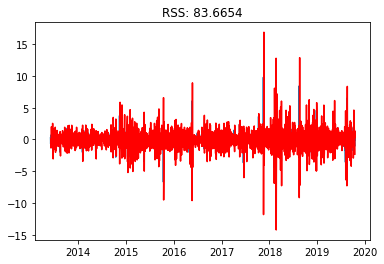

2 2 0
                 0        Close           out
count  1603.000000  1603.000000  1.603000e+03
mean     -0.000948     0.027555  4.366751e+00
std       1.861899     0.964462  1.506264e+01
min     -14.248088   -10.669998  8.928450e-07
25%      -0.888750    -0.409996  2.186180e-01
50%      -0.017443     0.040001  1.035314e+00
75%       0.853809     0.480003  3.424455e+00
max      16.880576     9.790001  2.846163e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


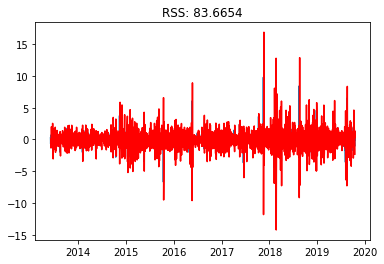

2 2 1
                 0        Close           out
count  1603.000000  1603.000000  1.603000e+03
mean     -0.000948     0.027555  4.366751e+00
std       1.861899     0.964462  1.506264e+01
min     -14.248088   -10.669998  8.928450e-07
25%      -0.888750    -0.409996  2.186180e-01
50%      -0.017443     0.040001  1.035314e+00
75%       0.853809     0.480003  3.424455e+00
max      16.880576     9.790001  2.846163e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


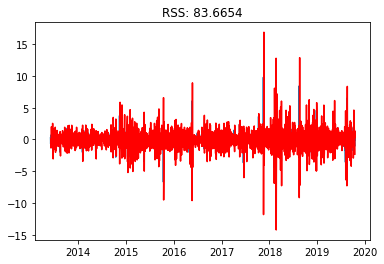

2 2 2
                 0        Close           out
count  1603.000000  1603.000000  1.603000e+03
mean     -0.000948     0.027555  4.366751e+00
std       1.861899     0.964462  1.506264e+01
min     -14.248088   -10.669998  8.928450e-07
25%      -0.888750    -0.409996  2.186180e-01
50%      -0.017443     0.040001  1.035314e+00
75%       0.853809     0.480003  3.424455e+00
max      16.880576     9.790001  2.846163e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


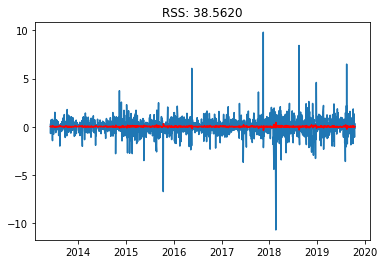

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3 0 0
                 0        Close           out
count  1605.000000  1605.000000  1.605000e+03
mean      0.027248     0.027246  9.264972e-01
std       0.047974     0.964043  4.636559e+00
min      -0.367740   -10.669998  2.571263e-07
25%       0.003808    -0.409996  3.615330e-02
50%       0.026681     0.040001  1.951344e-01
75%       0.051133     0.480003  6.596659e-01
max       0.449237     9.790001  1.121220e+02


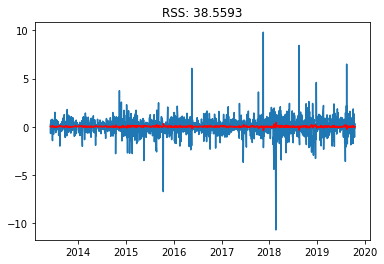

3 0 1
                 0        Close           out
count  1605.000000  1605.000000  1.605000e+03
mean      0.027249     0.027246  9.263691e-01
std       0.049288     0.964043  4.633039e+00
min      -0.373265   -10.669998  1.992122e-07
25%       0.003184    -0.409996  3.608305e-02
50%       0.026418     0.040001  1.963295e-01
75%       0.051068     0.480003  6.613273e-01
max       0.434801     9.790001  1.118947e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


38.558559783690995


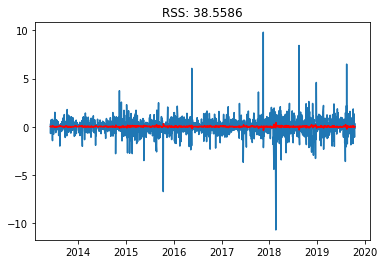

3 0 2
                 0        Close           out
count  1605.000000  1605.000000  1.605000e+03
mean      0.027249     0.027246  9.263318e-01
std       0.049664     0.964043  4.633472e+00
min      -0.370415   -10.669998  7.332359e-07
25%       0.003111    -0.409996  3.650782e-02
50%       0.026274     0.040001  1.969707e-01
75%       0.051830     0.480003  6.620076e-01
max       0.438337     9.790001  1.118345e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


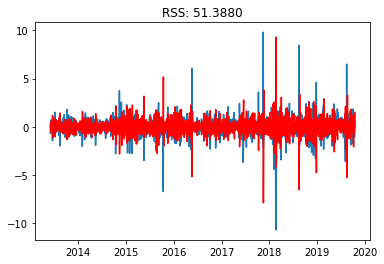

3 1 0
                 0        Close          out
count  1604.000000  1604.000000  1604.000000
mean     -0.000082     0.027107     1.646339
std       0.870823     0.964328     6.033859
min      -7.867174   -10.669998     0.000003
25%      -0.401748    -0.409998     0.078090
50%      -0.003322     0.040001     0.377130
75%       0.402626     0.480003     1.329815
max       9.264706     9.790001   140.534150


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


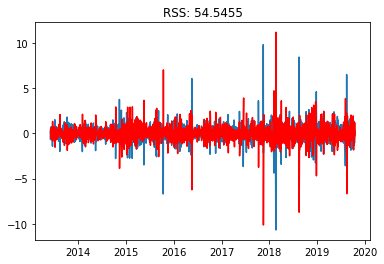

3 1 1
                 0        Close          out
count  1604.000000  1604.000000  1604.000000
mean      0.007420     0.027107     1.854872
std       1.004735     0.964328     7.111995
min     -10.126787   -10.669998     0.000003
25%      -0.459646    -0.409998     0.079378
50%      -0.010818     0.040001     0.407980
75%       0.453235     0.480003     1.433699
max      11.162382     9.790001   189.128108


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


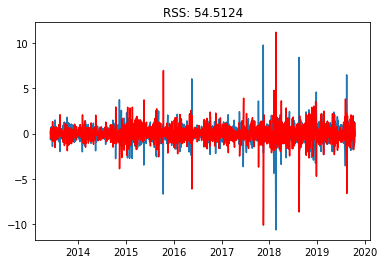

3 1 2
                 0        Close           out
count  1604.000000  1604.000000  1.604000e+03
mean      0.007412     0.027107  1.852618e+00
std       1.005780     0.964328  7.110224e+00
min     -10.139040   -10.669998  8.584801e-07
25%      -0.468201    -0.409998  8.158687e-02
50%      -0.000440     0.040001  4.240781e-01
75%       0.462982     0.480003  1.427325e+00
max      11.210398     9.790001  1.904511e+02


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


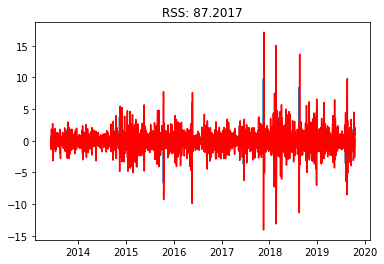

3 2 0
                 0        Close          out
count  1603.000000  1603.000000  1603.000000
mean     -0.000768     0.027555     4.743695
std       1.964184     0.964462    16.525552
min     -14.081000   -10.669998     0.000017
25%      -0.929399    -0.409996     0.207492
50%       0.002547     0.040001     1.151222
75%       0.896100     0.480003     3.883841
max      17.136333     9.790001   310.602108


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


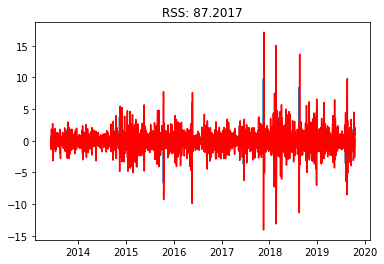

3 2 1
                 0        Close          out
count  1603.000000  1603.000000  1603.000000
mean     -0.000768     0.027555     4.743695
std       1.964184     0.964462    16.525552
min     -14.081000   -10.669998     0.000017
25%      -0.929399    -0.409996     0.207492
50%       0.002547     0.040001     1.151222
75%       0.896100     0.480003     3.883841
max      17.136333     9.790001   310.602108


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


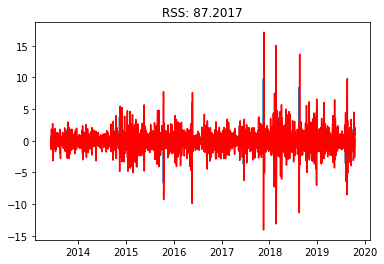

3 2 2
                 0        Close          out
count  1603.000000  1603.000000  1603.000000
mean     -0.000768     0.027555     4.743695
std       1.964184     0.964462    16.525552
min     -14.081000   -10.669998     0.000017
25%      -0.929399    -0.409996     0.207492
50%       0.002547     0.040001     1.151222
75%       0.896100     0.480003     3.883841
max      17.136333     9.790001   310.602108


In [23]:
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff, order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)
            print((x).describe())


In [24]:
loss_best

38.558559783690995

In [25]:
best_ints

[3, 0, 2]

Make sure you can get the stock data (you should have at least this part up and running)
**You can't use Apple - use a different company**
